## Test the tensorflow accuracy of softmax regression

In [22]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:


x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

numpy.ndarray

In [12]:
y_ = tf.placeholder(tf.float32, [None, 10])


#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = (tf.matmul(x, W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


In [13]:
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


In [14]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9057


## Switch to pure Python libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib notebook
mnist = fetch_mldata('MNIST original')

mnist.DESCR
# scaling is actually not needed, every pixel is measured on the same scale
#X = mnist.data / 255.
#y = mnist.target


DataTrain = pd.read_csv('train.csv')

features = DataTrain.columns[1:]
X = DataTrain[features]
y = DataTrain['label']


# prepare the datasets for analysis (all rows and columns are filled, no cleaning is necessary)

# 1% out of the whole bunch of data to see initial performance of the classifier:

X_train_percent, X_rest, y_train_percent, y_rest = train_test_split(X, y, test_size = 0.99, random_state=0)

# out of the rest split 10% for the training to simulate bandwith problem
#since the car is free to choose which data it can send we set the random state to None

X_train_car, X_rest2, y_train_car, y_rest2 = train_test_split(X_rest, y_rest, test_size = 0.9, random_state=None)

# use 10% of the rest of the data for testing

_1, X_test_car, _2, y_test_car = train_test_split(X_rest2, y_rest2, test_size = 0.1, random_state=0)

# check if we have 10% of the data for training and 10% of data for testing
print(X.shape, X_train_car.shape, X_test_car.shape)

(42000, 784) (4158, 784) (3743, 784)


## Visualize the data

<IPython.core.display.Javascript object>


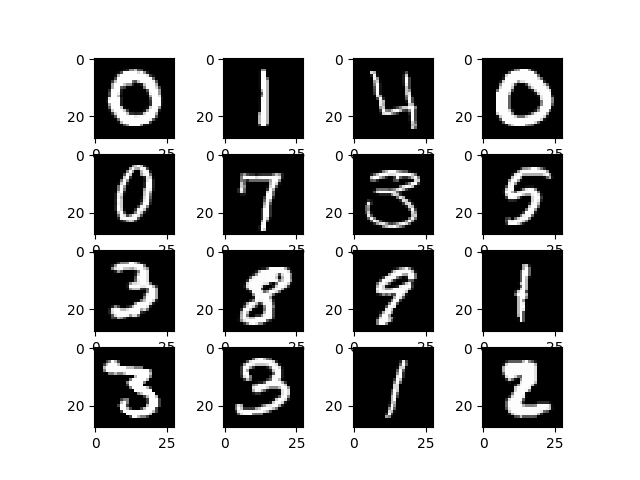

In [42]:
def plotData(ind):
    plt.imshow(np.reshape(np.array(DataTrain.iloc[ind,1:]), (28, 28)), cmap="gray")

def plotTrainData(ind):
    plt.imshow(np.reshape(np.array(X_test_car.iloc[ind]), (28, 28)), cmap="gray")

plt.figure()
for image in range(1, 17):
    plt.subplot(4, 4, image)
    plotData(image)

## Test some classifier, and their time performance

RF time 0.23558592796325684


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGD time 0.30589866638183594
kNN time 25.78494620323181


<IPython.core.display.Javascript object>


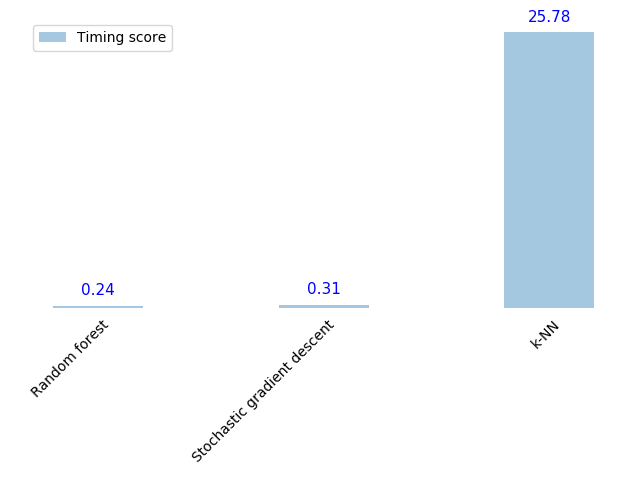

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC


perf_score_time = []

#Random Forest
rf = RandomForestClassifier()
start_time = time.time()
rf.fit(X_train_car, y_train_car)
rf.predict(X_test_car)
end_time = time.time() - start_time
print('RF time', end_time)
perf_score_time.append(end_time)

#stochastic gradient descent
sgd = SGDClassifier()
start_time = time.time()
sgd.fit(X_train_car, y_train_car)
sgd.predict(X_test_car)
end_time = time.time() - start_time
print('SGD time', end_time)
perf_score_time.append(end_time)

#k neigherst neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
start_time = time.time()
knn.fit(X_train_car, y_train_car)
y_pred = knn.predict(X_test_car)
end_time = time.time() - start_time
print('kNN time', end_time)
perf_score_time.append(end_time)


barwidth = 0.4


fig, ax = plt.subplots()
barplot = plt.bar(np.arange(len(perf_score_time)), perf_score_time, barwidth, align='center', alpha=0.4, label='Timing score')
plt.legend(loc='upper left')

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barplot]
plt.xticks(xticks_pos, ['Random forest', 'Stochastic gradient descent', 'k-NN'],  ha='right', rotation=45)
plt.tight_layout()

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
        
for bar in barplot:
    
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, '%.2f' % bar.get_height(), 
        ha='center', color='b', fontsize=11)
#plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(bar.get_height()) + ' s', 
#    ha='center', color='b', fontsize=11)
plt.show()

## Test classifiers performance on small data samples

(415, 784)
(831, 784)
(1247, 784)
(1663, 784)
(2079, 784)
(2494, 784)
(2910, 784)
(3326, 784)
(3742, 784)
(4158, 784)


<IPython.core.display.Javascript object>


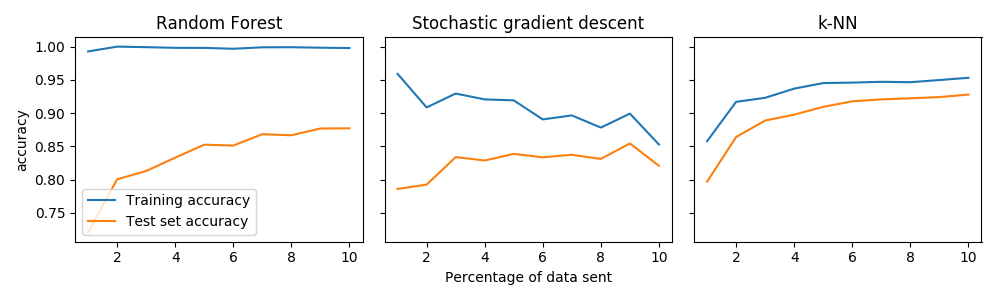

In [3]:
PercentagesTrainingSet = np.linspace(1,10,10)
PercentagesTrainingSet /= 10.


perf_train_clf_rf = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_rf = np.zeros(len(PercentagesTrainingSet))

perf_train_clf_sgd = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_sgd = np.zeros(len(PercentagesTrainingSet))

perf_train_clf_knn = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_knn = np.zeros(len(PercentagesTrainingSet))

for num, perc in enumerate(PercentagesTrainingSet):
    try:
        X_train_tmp, _1, y_train_tmp, _2 = train_test_split(X_train_car, y_train_car, test_size = 1-perc, random_state=0)
        print(X_train_tmp.shape)
        rf.fit(X_train_tmp, y_train_tmp)
        perf_train_clf_rf[num] = rf.score(X_train_tmp, y_train_tmp)
        perf_test_clf_rf[num] = rf.score(X_test_car, y_test_car)
                  
        sgd.fit(X_train_tmp, y_train_tmp)
        perf_train_clf_sgd[num] = sgd.score(X_train_tmp, y_train_tmp)
        perf_test_clf_sgd[num] = sgd.score(X_test_car, y_test_car)
        
        knn.fit(X_train_tmp, y_train_tmp)
        perf_train_clf_knn[num] = knn.score(X_train_tmp, y_train_tmp)
        perf_test_clf_knn[num] = knn.score(X_test_car, y_test_car)

        
    except:
        print('error')
    

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(10, 3))
ax1.set_title('Random Forest')
ax1.plot(PercentagesTrainingSet*10, perf_train_clf_rf, label = 'Training accuracy')
ax1.plot(PercentagesTrainingSet*10, perf_test_clf_rf, label = 'Test set accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('Percentage of data sent')
ax2.set_title('Stochastic gradient descent')
ax2.plot(PercentagesTrainingSet*10, perf_train_clf_sgd)
ax2.plot(PercentagesTrainingSet*10, perf_test_clf_sgd)
ax2.set_xlabel('Percentage of data sent')
ax3.set_title('k-NN')
ax3.plot(PercentagesTrainingSet*10, perf_train_clf_knn)
ax3.plot(PercentagesTrainingSet*10, perf_test_clf_knn)
ax3.set_xlabel('Percentage of data sent')
plt.tight_layout()
plt.show()

## Check if it helps to extract features e.g. reduce dimensions

<IPython.core.display.Javascript object>


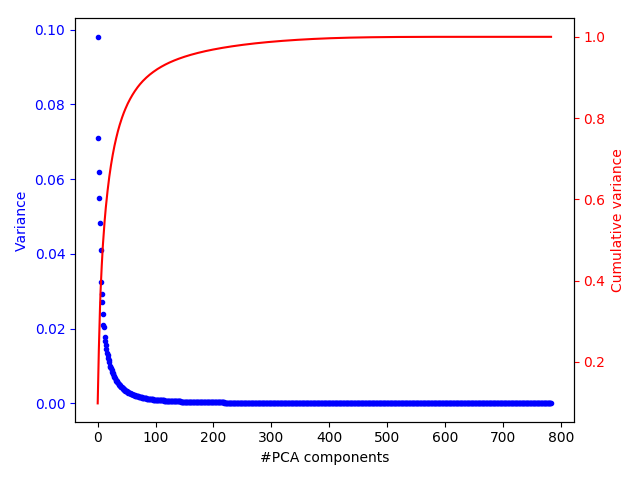

<IPython.core.display.Javascript object>


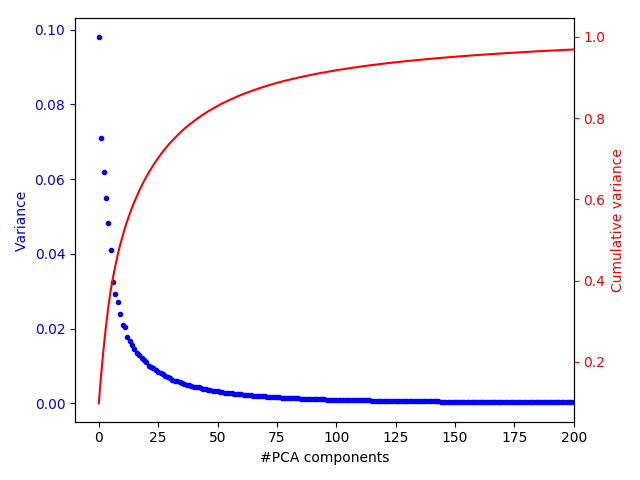

In [4]:
scaler = StandardScaler()

#all pixels are 'measured' on the same scale, for this reason don't standardize: it leads to some artefacts which have to
#be investigated further if there is time

#X_train_scaled = scaler.fit_transform(X_train_car)
#X_test_scaled = scaler.fit_transform(X_test_car)

#be careful not to get back complex eigenvalues, use eigh instead of eig
cov_mat = np.cov(X_train_car.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

total = sum(eigen_vals)
variance = [eig/total for eig in sorted(eigen_vals, reverse=True)]
cum_variance = np.cumsum(variance)

fig, ax1 = plt.subplots()
ax1.plot(variance, 'b.')
ax1.set_xlabel('#PCA components')
ax1.set_ylabel('Variance', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(cum_variance, 'r-')
ax2.set_ylabel('Cumulative variance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(variance, 'b.')
ax1.set_xlabel('#PCA components')
ax1.set_ylabel('Variance', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim(-10,200)

ax2 = ax1.twinx()
ax2.plot(cum_variance, 'r-')
ax2.set_ylabel('Cumulative variance', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

PCA transformation time: 0.37500977516174316


<IPython.core.display.Javascript object>


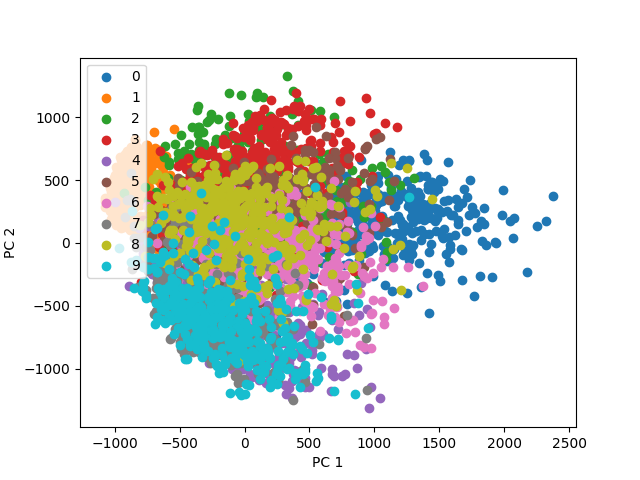

In [16]:
pca = PCA(n_components=30)

start_time = time.time()
X_train_car_pca = pca.fit_transform(X_train_car)
end_time = time.time() - start_time
X_test_car_pca = pca.transform(X_test_car)

print('PCA transformation time:', end_time)

f = plt.figure()

for number in range(10):
    plt.scatter(X_train_car_pca[:, 0][y_train_car == number], X_train_car_pca[:,1][y_train_car == number], label = str(number))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc=2)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4158 samples in 0.009s...
[t-SNE] Computed neighbors for 4158 samples in 1.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4158
[t-SNE] Computed conditional probabilities for sample 2000 / 4158
[t-SNE] Computed conditional probabilities for sample 3000 / 4158
[t-SNE] Computed conditional probabilities for sample 4000 / 4158
[t-SNE] Computed conditional probabilities for sample 4158 / 4158
[t-SNE] Mean sigma: 332.843608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.832954
[t-SNE] Error after 300 iterations: 1.946025


<IPython.core.display.Javascript object>


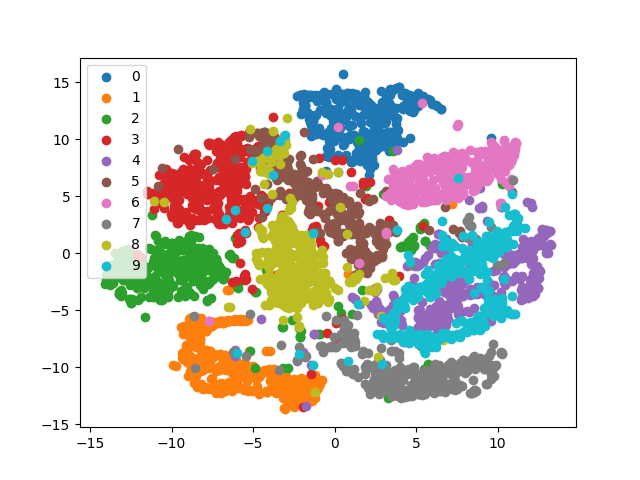

In [6]:
#visualize the dataset with t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_train_car_tsne = tsne.fit_transform(X_train_car_pca)

f2 = plt.figure()
for number in range(10):
    plt.scatter(X_train_car_tsne[:, 0][y_train_car == number], X_train_car_tsne[:,1][y_train_car == number], label = str(number))
plt.legend(loc = 2)
plt.show()

<IPython.core.display.Javascript object>


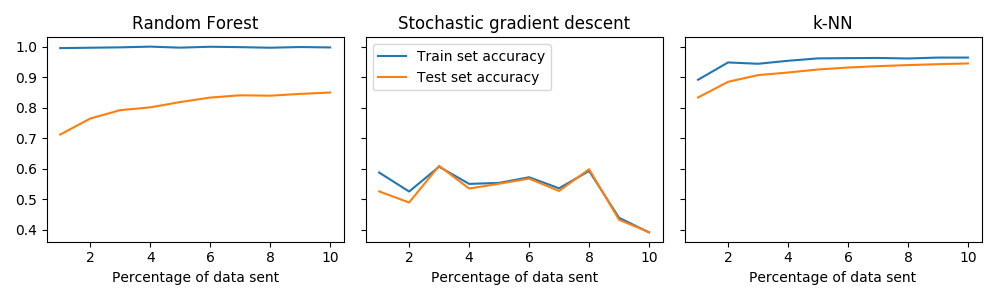

<IPython.core.display.Javascript object>


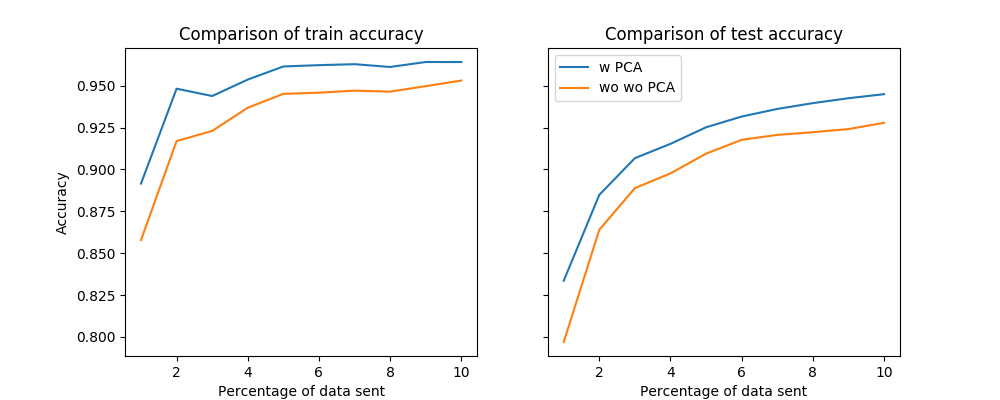

In [7]:
perf_train_clf_rf_pca = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_rf_pca = np.zeros(len(PercentagesTrainingSet))

perf_train_clf_sgd_pca = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_sgd_pca = np.zeros(len(PercentagesTrainingSet))

perf_train_clf_knn_pca = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_knn_pca = np.zeros(len(PercentagesTrainingSet))

for num, perc in enumerate(PercentagesTrainingSet):
    try:
        X_train_tmp, _1, y_train_tmp, _2 = train_test_split(X_train_car, y_train_car, test_size = 1-perc, random_state=0)       
        
        X_train_tmp_pca = pca.fit_transform(X_train_tmp)
        X_test_tmp_pca = pca.transform(X_test_car)
        
        rf.fit(X_train_tmp_pca, y_train_tmp)
        perf_train_clf_rf_pca[num] = rf.score(X_train_tmp_pca, y_train_tmp)
        perf_test_clf_rf_pca[num] = rf.score(X_test_tmp_pca, y_test_car)
        
        sgd.fit(X_train_tmp_pca, y_train_tmp)
        perf_train_clf_sgd_pca[num] = sgd.score(X_train_tmp_pca, y_train_tmp)
        perf_test_clf_sgd_pca[num] = sgd.score(X_test_tmp_pca, y_test_car)
        
        knn.fit(X_train_tmp_pca, y_train_tmp)
        perf_train_clf_knn_pca[num] = knn.score(X_train_tmp_pca, y_train_tmp)
        perf_test_clf_knn_pca[num] = knn.score(X_test_tmp_pca, y_test_car)
        
    except:
        print('error')
    

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,3))
ax1.set_title('Random Forest')
ax1.plot(PercentagesTrainingSet*10, perf_train_clf_rf_pca, label = 'Train set accuracy')
ax1.plot(PercentagesTrainingSet*10, perf_test_clf_rf_pca, label = 'Test set accuracy')
ax1.set_xlabel('Percentage of data sent')
ax2.set_title('Stochastic gradient descent')
ax2.plot(PercentagesTrainingSet*10, perf_train_clf_sgd_pca, label = 'Train set accuracy')
ax2.plot(PercentagesTrainingSet*10, perf_test_clf_sgd_pca, label = 'Test set accuracy')
ax2.legend(loc=2)
ax2.set_xlabel('Percentage of data sent')
ax3.set_title('k-NN')
ax3.plot(PercentagesTrainingSet*10, perf_train_clf_knn_pca, label = 'Train set accuracy')
ax3.plot(PercentagesTrainingSet*10, perf_test_clf_knn_pca, label = 'Test accuracy')
ax3.set_xlabel('Percentage of data sent')
plt.tight_layout()
plt.show()

#comparison of the k-NN test curves with and without PCA

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(PercentagesTrainingSet*10, perf_train_clf_knn_pca, label='w PCA')
ax1.plot(PercentagesTrainingSet*10, perf_train_clf_knn, label='wo PCA')
ax1.set_title('Comparison of train accuracy')
ax1.set_xlabel('Percentage of data sent')
ax1.set_ylabel('Accuracy')
ax2.plot(PercentagesTrainingSet*10, perf_test_clf_knn_pca, label='w PCA')
ax2.plot(PercentagesTrainingSet*10, perf_test_clf_knn, label='wo wo PCA')
ax2.legend(loc=2)
ax2.set_title('Comparison of test accuracy')
ax2.set_xlabel('Percentage of data sent')
plt.show()

## Hyperparameter tuning

In [8]:
from sklearn.model_selection import GridSearchCV

# tune a k-NN it looks like a promising candidate

PCAcomponents = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 25, 30, 35, 40, 45, 50, 60]

params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}


for pcacomp in PCAcomponents:

    pca = PCA(n_components=pcacomp)
    X_train_car_pca = pca.fit_transform(X_train_car)
    X_test_car_pca = pca.transform(X_test_car)
    

    knnmodels = GridSearchCV(knn, param_grid=params, cv=10)
    knnmodels.fit(X_train_car_pca, y_train_car)
    
    
    train_score = knnmodels.score(X_train_car_pca, y_train_car)
    test_score = knnmodels.score(X_test_car_pca, y_test_car)
    
    print('PCA component:', pcacomp, knnmodels.best_params_, 'train score', train_score,
          'test score', test_score, 'difference', train_score - test_score)


PCA component: 1 {'n_neighbors': 8} train score 0.433621933622 test score 0.269569863746 difference 0.164052069876
PCA component: 2 {'n_neighbors': 8} train score 0.551226551227 test score 0.424792946834 difference 0.126433604392
PCA component: 3 {'n_neighbors': 8} train score 0.601972101972 test score 0.485439487042 difference 0.11653261493
PCA component: 4 {'n_neighbors': 7} train score 0.709716209716 test score 0.611541544216 difference 0.0981746655003
PCA component: 5 {'n_neighbors': 7} train score 0.796055796056 test score 0.721613678867 difference 0.0744421171886
PCA component: 6 {'n_neighbors': 7} train score 0.852813852814 test score 0.801496126102 difference 0.0513177267118
PCA component: 7 {'n_neighbors': 7} train score 0.873015873016 test score 0.848250066791 difference 0.0247658062245
PCA component: 8 {'n_neighbors': 8} train score 0.896103896104 test score 0.870691958322 difference 0.0254119377817
PCA component: 9 {'n_neighbors': 7} train score 0.909090909091 test score 0.

## Evaluate the final model

0.7496137619018555
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'):
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       376
          1       0.94      0.99      0.96       407
          2       0.96      0.93      0.95       356
          3       0.94      0.94      0.94       400
          4       0.95      0.93      0.94       377
          5       0.92      0.94      0.93       317
          6       0.97      0.98      0.98       395
          7       0.94      0.92      0.93       382
          8       0.97      0.92      0.94       373
          9       0.89      0.91      0.90       360

avg / total       0.95      0.95      0.95      3743




<IPython.core.display.Javascript object>


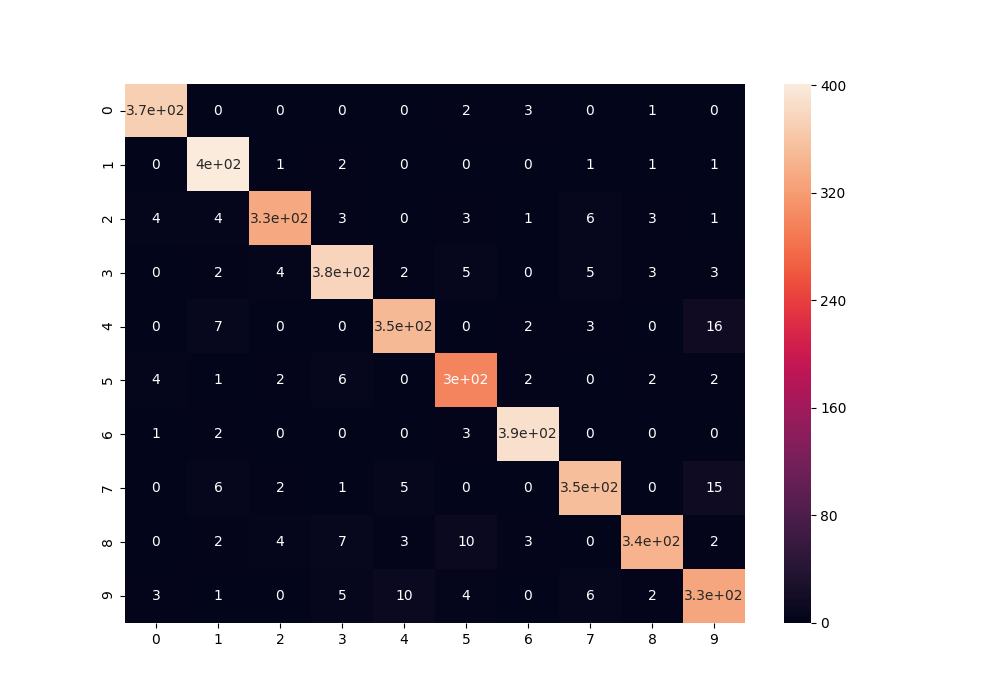

<IPython.core.display.Javascript object>


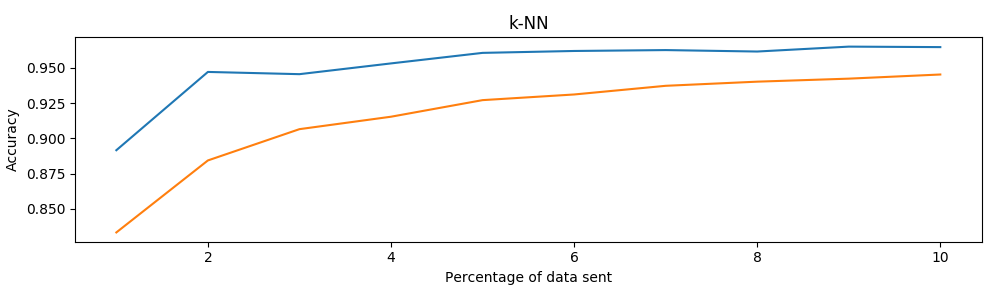

time for prediction 0.7438077926635742


<IPython.core.display.Javascript object>


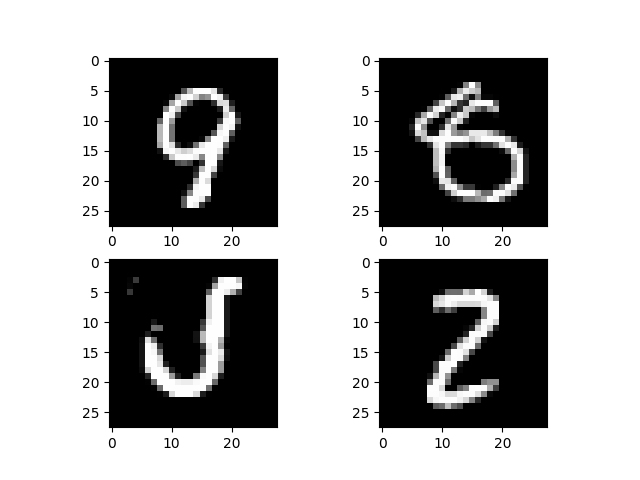

predicted 4 test 9
predicted 5 test 8
predicted 2 test 5
predicted 8 test 2


In [51]:
from sklearn import metrics
import seaborn as sns

# evaluate the confusion matrix



pca = PCA(n_components=30)
X_train_car_pca = pca.fit_transform(X_train_car)
X_test_car_pca = pca.transform(X_test_car)

knn = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
knn.fit(X_train_car_pca, y_train_car)
y_pred = knn.predict(X_test_car_pca)
end_time = time.time() - start_time
print(end_time)

cm = metrics.confusion_matrix(y_test_car, y_pred)

print("Classification report for classifier %s:\n%s\n"
      % (knn, metrics.classification_report(y_test_car, y_pred)))
#print("Confusion matrix:\n%s" % cm)

df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()


perf_train_clf_knn_pca = np.zeros(len(PercentagesTrainingSet))
perf_test_clf_knn_pca = np.zeros(len(PercentagesTrainingSet))

for num, perc in enumerate(PercentagesTrainingSet):
    try:
        X_train_tmp, _1, y_train_tmp, _2 = train_test_split(X_train_car, y_train_car, test_size = 1-perc, random_state=0)       
        
        X_train_tmp_pca = pca.fit_transform(X_train_tmp)
        X_test_tmp_pca = pca.transform(X_test_car)
        
        
        knn.fit(X_train_tmp_pca, y_train_tmp)
        perf_train_clf_knn_pca[num] = knn.score(X_train_tmp_pca, y_train_tmp)
        perf_test_clf_knn_pca[num] = knn.score(X_test_tmp_pca, y_test_car)
        
    except:
        print('error')
    


f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10,3))


ax1.set_title('k-NN')
ax1.plot(PercentagesTrainingSet*10, perf_train_clf_knn_pca, label = 'Train set accuracy')
ax1.plot(PercentagesTrainingSet*10, perf_test_clf_knn_pca, label = 'Test accuracy')
ax1.set_xlabel('Percentage of data sent')
ax1.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()


start_time = time.time()
knn.fit(X_train_car_pca, y_train_car)    
y_pred = knn.predict(X_test_car_pca)    
end_time = time.time() - start_time
print('time for prediction', end_time)


f = plt.figure()
#check the numbers where the classifier fails
image = 1
for num, yval in enumerate(y_pred):
    if yval != y_test_car.iloc[num]:
        plt.subplot(2, 2, image)
        print('predicted', yval, 'test', y_test_car.iloc[num])
        plotTrainData(num)
        image += 1
        if image == 5: break